In [53]:
import matplotlib.pyplot as plt 
import numpy as np
import scipy.io.wavfile
import scipy.signal
import wave, struct
import pandas as pd
from scipy.signal import butter, freqz, filtfilt
from scipy.signal import find_peaks
from scipy.fft import rfft, fft, fftfreq, rfftfreq
from scipy import stats
from sklearn.metrics import confusion_matrix
import seaborn as sns
import glob, os
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
import flirt.reader.empatica
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
import os
import warnings
warnings.filterwarnings('ignore')

os.chdir('/Users/sohinib/Downloads/WESAD')
os.listdir(os.getcwd())
os.getcwd()

'/Users/sohinib/Downloads/WESAD'

## Changed the directory to the WESAD folder, to get the folders for each subject.

## label: 1: stress, 0: no stress. 

Initiaized the variables and models.

In [54]:
ss = StandardScaler()

lr = LogisticRegression(random_state = 0)

knn = KNeighborsClassifier(n_neighbors=2)

cv = KFold(n_splits=10, random_state=1, shuffle=True)

model = keras.Sequential(
    [keras.layers.Dense(100,input_shape=(173,), activation='relu'),
     keras.layers.Dense(100, activation='relu'),
     keras.layers.Dense(1, activation='sigmoid')])

model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

target_names = ['0','1']

window_size = 60
step_size = 10

    
for fname in os.listdir(os.getcwd()):
    if (fname.endswith('.pdf') or fname.endswith('.DS_Store')):
        f=fname
        os.remove(os.path.join(os.getcwd(),fname))
    
folders = os.listdir(os.getcwd())
print("folders:",folders)

test_folders = os.listdir(os.getcwd())[10:]
train_folders = os.listdir(os.getcwd())[:10]


folders: ['S5', 'S2', 'S3', 'S4', 'S17', 'S10', 'S11', 'S16', 'S6', 'S7', 'S13', 'S14', 'S15']


In [55]:
len(train_folders)

10

## The "get_timestamps" function gets the start and end timestamps of the base and tsst states from the csv file.
### Then it converts it to seconds and gives the normalized timestamps.

In [56]:
       
def get_timestamps(item):
    label_file = pd.read_csv(os.getcwd()+"/"+item+"/"+item+"_quest.csv",sep=";")
    # [0] = minutes; [1] = seconds
    base_start = label_file.iloc[1,1].split(".")
    base_end = label_file.iloc[2,1].split(".")
    tsst_start = label_file.iloc[1,2].split(".")
    tsst_end = label_file.iloc[2,2].split(".")
    
    if(len(base_start)>1):
        base_start_normalized = int(base_start[0])*60 + int(base_start[1])
    else:
        base_start_normalized = int(base_start[0])*60

    if(len(base_end)>1):
        base_end_normalized = int(base_end[0])*60 + int(base_end[1])
    else:
        base_end_normalized = int(base_end[0])*60

    if(len(tsst_start)>1):
        tsst_start_normalized = int(tsst_start[0])*60 + int(tsst_start[1])
    else:
        tsst_start_normalized = int(tsst_start[0])*60

    if(len(tsst_end)>1):
        tsst_end_normalized = int(tsst_end[0])*60 + int(tsst_end[1])
    else:
        tsst_end_normalized = int(tsst_end[0])*60
        
    return base_start_normalized,base_end_normalized,tsst_start_normalized,tsst_end_normalized


## The "create_dataset" function opens each user's folders and gets the hrv, acc and eda features form the zip file.
### Then "normalized_time" (labels the dataset to 0 and 1, drops the rest)and "user" (to specify each user's data) column get added.
### Returns x and y datasets.

In [57]:
def create_dataset(folders=folders):

    data = pd.DataFrame()
#     train_data = pd.DataFrame()
    x = pd.DataFrame()
    y = pd.DataFrame()

    for item in folders:
        b_s,b_e,t_s,t_e = get_timestamps(item)
        features = flirt.simple.get_features_for_empatica_archive(os.getcwd()+"/"+item+"/"+item+"_E4_Data.zip", window_size, step_size, hrv_features=True, eda_features=True, acc_features=True)
        features["normalized_time"] = features.index.second + features.index.minute*60 + features.index.hour*60*60
    
        b_start = features["normalized_time"][0] + b_s
        b_end = features["normalized_time"][0] + b_e
        t_start = features["normalized_time"][0] + t_s
        t_end= features["normalized_time"][0] + t_e
    
        features["label"] = 2
        
        b = features.loc[(features["normalized_time"]>=b_start) & (features["normalized_time"]<=b_end)]["label"].replace(2,0)
        t = features.loc[(features["normalized_time"]>=t_start) & (features["normalized_time"]<=t_end)]["label"].replace(2,1)
        
        features.update(b)
        features.update(t)
                
        features = features[features.label!=2]
        features["user"] = item
        
        data = pd.concat([data,features],axis=0)
        
        
    y = data[["label","user"]]
    data.drop(["label","normalized_time"],axis=1,inplace=True)
    x=data
        
    return x,y

## The "clean_data" function converts nan values to num, fills na with mean and uses SimpleImputer to fill np.nan with mean.

In [58]:
def clean_data(x,y):

    x_user = x.user
    x_user = x_user.reset_index()
    x_user.drop("index",axis=1,inplace=True)
    
    x.drop("user",inplace=True,axis=1)
    x = np.nan_to_num(x)
    x = pd.DataFrame(x)

    x = x.fillna(x.mean())
    x = pd.DataFrame(x)
    x = imputer.fit_transform(x)

    x_clean = pd.DataFrame(x)
    x_clean["user"] = x_user
    
    y_user = y.user
    y_user = y_user.reset_index()
    y_user.drop("index",axis=1,inplace=True)
    
    y.drop("user",inplace=True,axis=1)
    y = np.nan_to_num(y)
    y = pd.DataFrame(y)

    y = y.fillna(y.mean())

    y_clean = pd.DataFrame(y)
    y_clean["user"] = y_user
    
    return x_clean,y_clean

## The "leave_one_subject_cross_val" function returns the cross validation scores for each user.
### Using pipeline to scale the dataset first then put it through logistic regression.
### Returns a DataFrame consisting of the cross-val score leaving one subject out each time as the test data.

In [59]:
def leave_one_subject_cross_val(x_clean,y_clean,folders=folders):

    pipe = Pipeline([('scaler', ss), ("logistic", lr)])
    score_array = []
    for name in folders:

        x_test_user  = x_clean[x_clean.user==name]
        x_test_user.drop("user",inplace=True,axis=1)
        y_test_user = y_clean[y_clean.user==name]
        y_test_user.drop("user",inplace=True,axis=1)
        x_train_user  = x_clean[x_clean.user!=name]
        x_train_user.drop("user",inplace=True,axis=1)
        y_train_user = y_clean[y_clean.user!=name]
        y_train_user.drop("user",inplace=True,axis=1)
        pipe.fit(x_train_user,y_train_user)
        score = pipe.score(x_test_user,y_test_user)
        
        score_array.append([name,score]) 

    return pd.DataFrame(score_array)


## The "create_train_test" function creates training (first 10 users in the WESAD folder) and testing (rest 3 users) data.
### Concatenates the different user data and drops the user column, as no longer needed.
### Returns x_train,x_test,y_train,y_test.

In [60]:
def create_train_test(x_clean,y_clean,train_folders=train_folders,test_folders=test_folders):
    x_train = pd.DataFrame()
    x_test = pd.DataFrame()
    y_train = pd.DataFrame()
    y_test = pd.DataFrame()
    data_x = pd.DataFrame()
    data_y = pd.DataFrame()

    for item in train_folders:
        data_y = y_clean[y_clean.user==item]
        data_x = x_clean[x_clean.user==item]

        y_train = pd.concat([y_train,data_y])
        x_train = pd.concat([x_train,data_x],axis=0)
        
        x_train.drop("user",axis=1,inplace=True)
        y_train.drop("user",axis=1,inplace=True)
        
    for item in test_folders:
        data_y = y_clean[y_clean.user==item]
        data_x = x_clean[x_clean.user==item]

        y_test = pd.concat([y_test,data_y])
        x_test = pd.concat([x_test,data_x],axis=0)
    
        x_test.drop("user",axis=1,inplace=True)
        y_test.drop("user",axis=1,inplace=True)
        
        return x_train,x_test,y_train,y_test

## Getting x & y.

In [61]:
x,y = create_dataset()

HRV features: 100%|██████████| 699/699 [00:36<00:00, 19.23it/s]


EDA features:   0%|          | 0/756 [00:00<?, ?it/s]

ACC features:   0%|          | 0/756 [00:00<?, ?it/s]

HRV features: 100%|██████████| 779/779 [00:01<00:00, 628.07it/s]


EDA features:   0%|          | 0/788 [00:00<?, ?it/s]

ACC features:   0%|          | 0/788 [00:00<?, ?it/s]

HRV features: 100%|██████████| 748/748 [00:00<00:00, 1296.18it/s]


EDA features:   0%|          | 0/773 [00:00<?, ?it/s]

ACC features:   0%|          | 0/773 [00:00<?, ?it/s]

HRV features: 100%|██████████| 778/778 [00:01<00:00, 756.57it/s]


EDA features:   0%|          | 0/800 [00:00<?, ?it/s]

ACC features:   0%|          | 0/800 [00:00<?, ?it/s]

HRV features: 100%|██████████| 710/710 [00:01<00:00, 669.73it/s]


EDA features:   0%|          | 0/724 [00:00<?, ?it/s]

ACC features:   0%|          | 0/724 [00:00<?, ?it/s]

HRV features: 100%|██████████| 673/673 [00:01<00:00, 431.45it/s]


EDA features:   0%|          | 0/683 [00:00<?, ?it/s]

ACC features:   0%|          | 0/683 [00:00<?, ?it/s]

HRV features: 100%|██████████| 629/629 [00:01<00:00, 517.54it/s]


EDA features:   0%|          | 0/647 [00:00<?, ?it/s]

ACC features:   0%|          | 0/647 [00:00<?, ?it/s]

HRV features: 100%|██████████| 703/703 [00:01<00:00, 500.23it/s]


EDA features:   0%|          | 0/711 [00:00<?, ?it/s]

ACC features:   0%|          | 0/711 [00:00<?, ?it/s]

HRV features: 100%|██████████| 809/809 [00:01<00:00, 768.34it/s]


EDA features:   0%|          | 0/833 [00:00<?, ?it/s]

ACC features:   0%|          | 0/833 [00:00<?, ?it/s]

HRV features: 100%|██████████| 641/641 [00:01<00:00, 518.37it/s]


EDA features:   0%|          | 0/650 [00:00<?, ?it/s]

ACC features:   0%|          | 0/650 [00:00<?, ?it/s]

HRV features: 100%|██████████| 663/663 [00:00<00:00, 1391.85it/s]


EDA features:   0%|          | 0/687 [00:00<?, ?it/s]

ACC features:   0%|          | 0/687 [00:00<?, ?it/s]

HRV features: 100%|██████████| 691/691 [00:02<00:00, 293.78it/s]


EDA features:   0%|          | 0/699 [00:00<?, ?it/s]

ACC features:   0%|          | 0/699 [00:00<?, ?it/s]

HRV features: 100%|██████████| 656/656 [00:01<00:00, 387.48it/s]


EDA features:   0%|          | 0/665 [00:00<?, ?it/s]

ACC features:   0%|          | 0/665 [00:00<?, ?it/s]

## Getting clean datasets.

In [62]:
x_clean,y_clean = clean_data(x,y)

## Leave one subject/user out cross validation scores (accuracy measure).

In [63]:
cross_val_scores = leave_one_subject_cross_val(x_clean,y_clean,folders)
cross_val_scores.set_index(cross_val_scores[0],inplace=True)
cross_val_scores.drop([0],axis=1,inplace=True)

cross_val_scores

,1
0,
S5,0.833333
S2,0.814607
S3,0.879121
S4,0.864516
S17,0.820988
S10,0.855346
S11,0.794737
S16,0.766839
S6,0.791444


## Getting x_train,x_test,y_train,y_test.

In [64]:
x_train,x_test,y_train,y_test = create_train_test(x_clean,y_clean)

## Using StandardScaler to scale the raw data for the neural network.

In [65]:
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

## Neural Network Model
#### input shape: 173
#### 1st layer:   activation -> relu;   100 nodes
#### 2nd layer:   activation -> relu;   100 nodes
#### 3rd layer: activation -> sigmoid;   1
#### loss:  binary_crossentropy, optimizer:  adam, metrics:  accuracy

#### epochs: 20, batch_size: 1 

In [66]:
model.fit(x_train_ss,y_train,epochs=20,batch_size=1) 
# BEST

Epoch 1/20
1726/1726 [==============================] - 5s 3ms/step - loss: 0.1835 - accuracy: 0.9311
Epoch 2/20
1726/1726 [==============================] - 4s 3ms/step - loss: 0.0604 - accuracy: 0.9809
Epoch 3/20
1726/1726 [==============================] - 6s 3ms/step - loss: 0.0270 - accuracy: 0.9913
Epoch 4/20
1726/1726 [==============================] - 4s 2ms/step - loss: 0.0296 - accuracy: 0.9890
Epoch 5/20
1726/1726 [==============================] - 4s 2ms/step - loss: 0.0140 - accuracy: 0.9965
Epoch 6/20
1726/1726 [==============================] - 4s 2ms/step - loss: 0.0248 - accuracy: 0.9913
Epoch 7/20
1726/1726 [==============================] - 4s 2ms/step - loss: 0.0284 - accuracy: 0.9948
Epoch 8/20
1726/1726 [==============================] - 4s 2ms/step - loss: 7.2348e-04 - accuracy: 1.0000
Epoch 9/20
1726/1726 [==============================] - 6s 3ms/step - loss: 0.0333 - accuracy: 0.9873
Epoch 10/20
1726/1726 [==============================] - 6s 4ms/step - loss: 0

In [67]:
model.evaluate(x_test_ss,y_test)

5/5 [==============================] - 0s 2ms/step - loss: 5.5462 - accuracy: 0.8938


[5.546237468719482, 0.893750011920929]

In [68]:
ind = 0
for i in model.predict(x_test_ss):
    if i>0.5:
        y_pred_nn[ind] = 1
    else:
        y_pred_nn[ind] = 0
    ind = ind + 1 

#### The classification report is given below.
#### Accuracy: 89%

In [69]:
print("nn model")
print(classification_report(y_test, y_pred_nn, target_names=target_names))

nn model
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       120
           1       1.00      0.57      0.73        40

    accuracy                           0.89       160
   macro avg       0.94      0.79      0.83       160
weighted avg       0.91      0.89      0.88       160



## Confusion Matrix NN

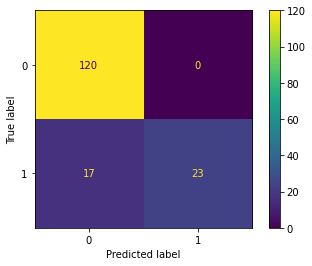

In [70]:
cm_knn = confusion_matrix(y_test, y_pred_nn)
cm_knn_display= metrics.ConfusionMatrixDisplay(confusion_matrix = cm_knn, display_labels = target_names)
cm_knn_display.plot()

## K-NN
#### Used a pipeline with StandardScaler.
#### The classification report is given below.
#### Accuracy: 85%

In [71]:
pipe = Pipeline([('scaler', ss), ("knn", knn)])
pipe.fit(x_train,y_train)
y_pred_knn = pipe.predict(x_test)
print("Accuracy: " + str(pipe.score(x_test,y_test)))
print("k nearest neighbour")
print(classification_report(y_test, y_pred_knn, target_names=target_names))

Accuracy: 0.85
k nearest neighbour
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       120
           1       1.00      0.40      0.57        40

    accuracy                           0.85       160
   macro avg       0.92      0.70      0.74       160
weighted avg       0.88      0.85      0.82       160



In [72]:
## 10 Fold Cross Val 


In [73]:
scores_knn = cross_val_score(knn, x_train, y_train, scoring='accuracy', cv=cv)
scores_knn

array([0.79190751, 0.89017341, 0.83815029, 0.84393064, 0.84971098,
       0.87861272, 0.81395349, 0.8255814 , 0.83139535, 0.86046512])

## Confusion Matrix K-NN

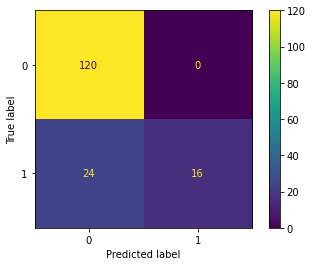

In [74]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_knn_display= metrics.ConfusionMatrixDisplay(confusion_matrix = cm_knn, display_labels = target_names)
cm_knn_display.plot()

## Logistic Regression 
#### Used a pipeline with StandardScaler.
#### The classification report is given below.
#### Accuracy: 90%

In [75]:
pipe = Pipeline([('scaler', ss), ("logistic", lr)])
pipe.fit(x_train,y_train)
y_pred_lr = pipe.predict(x_test)
# y_pred_lr = pd.DataFrame(y_pred_lr)
print("Accuracy: " + str(pipe.score(x_test,y_test)))
print("logistic regression")
print(classification_report(y_test, y_pred_lr, target_names=target_names))

Accuracy: 0.9
logistic regression
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       120
           1       1.00      0.60      0.75        40

    accuracy                           0.90       160
   macro avg       0.94      0.80      0.84       160
weighted avg       0.91      0.90      0.89       160



## Confusion Matrix Logistic Regression

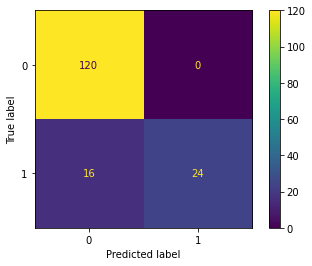

In [76]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_lr_display= metrics.ConfusionMatrixDisplay(confusion_matrix = cm_lr, display_labels = target_names)
cm_lr_display.plot()